In [3]:
import cv2
import numpy as np
import sys
import os 
from pdf2image import convert_from_path
import easyocr
import math
import re
import matplotlib.pyplot as plt

In [4]:
# pdf 路徑
pdf_path = "..\\..\\data\\pdf\\BoredPile\\rebar_all.pdf"

# 輸出路徑
output_path = "result.xml"

# create dic to store the result
'''
要抓得資料有:
1. 型號
2. 直徑
3. 長度
4. 繫樑長寬
5. 簡力筋號數
6. 箍筋號數
7. 混凝土強度
'''

final_result ={}

single_type_result = {
    "type": None,
    "diameter": None,
    "depth": None,
    "TieBeam": [],
    "ShearRebar": None,
    "Stirrup": None,
    "ConcreteStrength": None
}

True

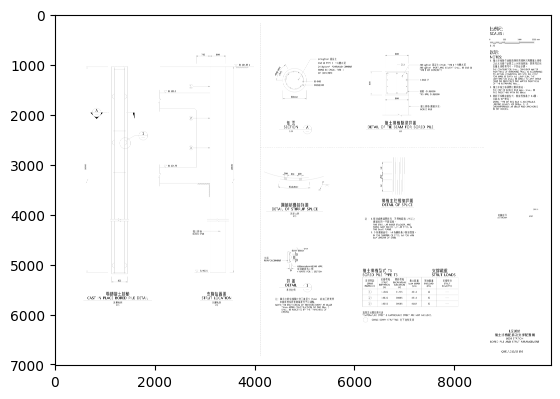

In [5]:
images = convert_from_path(pdf_path, dpi =300)

cv2_img = cv2.cvtColor(np.asarray(images[0]),cv2.COLOR_RGB2BGR)
img_gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
_, img_th = cv2.threshold (img_gray, 240, 255, 0)
img_blur = cv2.GaussianBlur(img_th, (5, 5), 0)
plt.imshow(img_blur, cmap='gray')
cv2.imwrite("rebar_blur.jpg", img_blur)

In [7]:
reader = easyocr.Reader(['en'])
bounds = reader.readtext(img_th, detail=1)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [31]:
# rotated image clockwise 90 degree
img_rotated = cv2.rotate(img_th, cv2.ROTATE_90_CLOCKWISE)
bounds_rotated = reader.readtext(img_rotated, detail=1)

### 用橫向的抓除了深度以外的資料

In [8]:
TieBeam = None # 格式為 [x, y]
BoardPileDetial = None # 格式為 [x, y]
Section = None # 格式為 [x, y]
listOfNumbers = [] # 儲存格式為 [數字, [x, y], index]
listOfShearRebars = [] # 儲存格式為 [文字, [x, y], index]
listOfstirrups = [] # 儲存格式為 [文字, [x, y], index]
listOfstrength = [] # 儲存格式為 [文字, [x, y], index

for i, bound in enumerate(bounds):
    # 找繫樑標註關鍵字
    if bound[1].find("TIE BEAM FOR BORED PILE") != -1:
        TieBeam = bound[0][0]
    # 找出排樁標註關鍵字
    elif bound[1].find("BORED PILE DETAIL") != -1:
        BoardPileDetial = bound[0][0]
    # 找出排樁斷面標註關鍵字
    elif bound[1].find("SECTION") != -1:
        area = (bound[0][0][0] - bound[0][1][0]) * (bound[0][0][1] - bound[0][2][1])
        if area > 15000:
            Section = bound[0][0]


    # 找出排樁型式
    match = re.match(r'^BORED PILE TYPE ([A-Z]\d+)$', bound[1])
    if match:
        extracted = match.group(1)
        single_type_result["type"] = extracted

    # 找出剪力筋號數
    match = re.match(r'D(\d+)@(\d+)', bound[1])
    if match:
        listOfShearRebars.append([bound[1], bound[0][0], i])

    # 找出箍筋號數
    match = re.match(r'(\d+)-D(\d+)', bound[1])
    if match:
        listOfstirrups.append([bound[1], bound[0][0], i])

    # 找出混凝土強度
    match = re.match(r'(\d+) kgf.*', bound[1])
    if match:
        listOfstrength.append([int(match.group(1)), bound[0][0], i])

    # 找出可以被轉換成int的數字 (預設是標註的那些數字)
    try:
        listOfNumbers.append([int(bound[1]), bound[0][0], i])
    except:
        pass


# according to the x,y points of bored pile detail, find the most closest int number with using listOfNumbers
if TieBeam == None or listOfNumbers == []:
    print("TieBeam or listOfNumbers is None")
    single_type_result["TieBeam"] = 'None'
else:
    min_distance = math.inf
    TeiBeam_index = -1
    for i in range(len(listOfNumbers)):
        distance = math.sqrt((listOfNumbers[i][1][0] - TieBeam[0])**2 + (listOfNumbers[i][1][1] - TieBeam[1])**2)
        if distance < min_distance:
            min_distance = distance
            TeiBeam_index = i

    single_type_result["TieBeam"] = listOfNumbers[TeiBeam_index][0]

if BoardPileDetial == None or listOfNumbers == []:
    print("BoardPileDetial or listOfNumbers is None")
    single_type_result["diameter"] = 'None'
else:
    min_distance = math.inf
    BoardPile_index = -1
    for i in range(len(listOfNumbers)):
        distance = math.sqrt((listOfNumbers[i][1][0] - BoardPileDetial[0])**2 + (listOfNumbers[i][1][1] - BoardPileDetial[1])**2)
        if distance < min_distance:
            min_distance = distance
            BoardPile_index = i

    single_type_result["diameter"] = listOfNumbers[BoardPile_index][0]

if Section == None or listOfShearRebars == []:
    print("Section or listOfShearRebars is None")
    single_type_result["ShearRebar"] = 'None'
else:
    min_distance = math.inf
    ShearRebar_index = -1
    for i in range(len(listOfShearRebars)):
        distance = math.sqrt((listOfShearRebars[i][1][0] - Section[0])**2 + (listOfShearRebars[i][1][1] - Section[1])**2)
        if distance < min_distance:
            min_distance = distance
            ShearRebar_index = i

    single_type_result["ShearRebar"] = listOfShearRebars[ShearRebar_index][0]

if Section == None or listOfstirrups == []:
    print("Section or listOfstirrups is None")
    single_type_result["Stirrup"] = 'None'
else:
    min_distance = math.inf
    Stirrup_index = -1
    for i in range(len(listOfstirrups)):
        distance = math.sqrt((listOfstirrups[i][1][0] - Section[0])**2 + (listOfstirrups[i][1][1] - Section[1])**2)
        if distance < min_distance:
            min_distance = distance
            Stirrup_index = i

    single_type_result["Stirrup"] = listOfstirrups[Stirrup_index][0]

if Section == None or listOfstrength == []:
    print("Section or listOfstrength is None")
    single_type_result["ConcreteStrength"] = 'None'
else:
    min_distance = math.inf
    ConcreteStrength_index = -1
    for i in range(len(listOfstrength)):
        distance = math.sqrt((listOfstrength[i][1][0] - Section[0])**2 + (listOfstrength[i][1][1] - Section[1])**2)
        if distance < min_distance:
            min_distance = distance
            ConcreteStrength_index = i

    single_type_result["ConcreteStrength"] = listOfstrength[ConcreteStrength_index][0]



### 用直向的抓深度

In [32]:
try:
    single_type_result["depth"] = int(bounds_rotated[0][1])
except:
    print("depth is None")
    single_type_result["depth"] = 'None'

In [9]:
print(single_type_result)

{'type': 'T3', 'diameter': 800, 'depth': None, 'TieBeam': 800, 'ShearRebar': 'D13@300', 'Stirrup': '10-D32', 'ConcreteStrength': 245}
